# R-Anode Gravitational Wave Demo

Generate toy gravitational wave background and signal events

Preprocess and split the data into sidebands (control) and signal regions

Train the background density estimator (normalizing flow)

Train the residual signal flow with a fixed signal fraction hypothesis

Evaluate the learned anomaly score on a held-out sample


All heavy Luigi/Law orchestration is skipped so the core R-Anode logic can be inspected interactively.

In [9]:
import os
import sys
import copy
import json
import pathlib
import numpy as np
import pandas as pd
import scipy
import torch

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ensure project root (with 'config/' and 'src/') is on sys.path
project_root = pathlib.Path.cwd().resolve()
if not (project_root / "config").exists():
    candidate = project_root.parent
    if (candidate / "config").exists():
        project_root = candidate
if (project_root / "config").exists() and str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
print(f"Using project root: {project_root}")

from config import configs
from src.data_prep.gw_processing import process_gw_backgrounds, process_gw_signals, gw_background_split
from src.data_prep.utils import preprocess_params_fit, logit_transform, standardize, inverse_transform
from src.models.model_B import DensityEstimator, anode
from src.models.model_S import flows_model_RQS, r_anode_mass_joint_untransformed
from scipy.stats import rv_histogram

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == "mps":
    torch.set_default_dtype(torch.float32)
torch.set_default_dtype(torch.float32)

torch.manual_seed(42)


Using project root: /Users/krishwu/code/ranode
Using device: mps


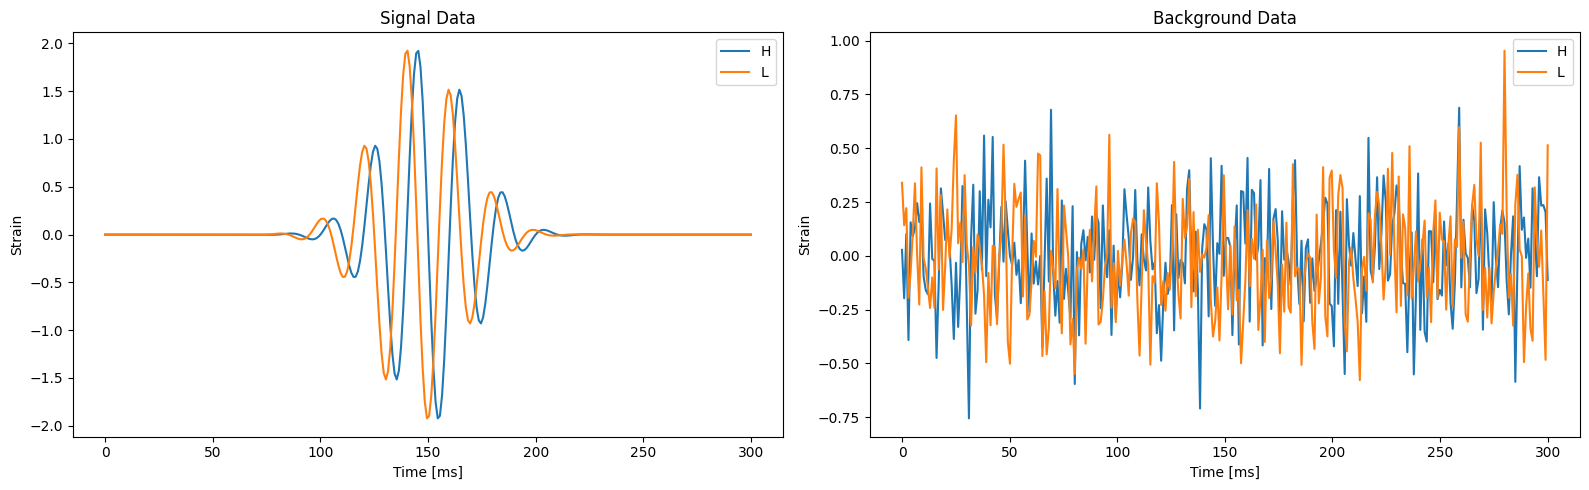

In [10]:
def gen_sig(amplitude=100.0):
    """Generate toy signal data mimicking gravitational wave detection.
    
    Parameters
    ----------
    amplitude : float, default=100.0
        Signal amplitude scaling factor
    
    Returns
    -------
    numpy.ndarray
        Generated signal data with gravitational wave-like characteristics
    """
    T = 20.0 # ms
    delta = 5. # ms
    A = amplitude
    return gen_data(A,T,delta,0)

def gen_bg():
    """Generate toy background data for gravitational wave analysis.
    
    Returns
    -------
    numpy.ndarray
        Generated background data without signal components
    """
    T = 20.0 # ms
    delta = 5. # ms
    A = 0.0
    return gen_data(A,T,delta,0.25)

def gen_data(A, T, delta, noise):
    """Generate simulated gravitational wave detector data.
    
    Creates toy data mimicking gravitational wave signals in dual detectors
    with configurable amplitude, period, time delay, and noise levels.
    
    Parameters
    ----------
    A : float
        Signal amplitude
    T : float
        Signal period in milliseconds
    delta : float
        Time delay between detectors in milliseconds
    noise : float
        Gaussian noise standard deviation
        
    Returns
    -------
    numpy.ndarray, shape (100, 5)
        Generated data with columns [time, H_detector, L_detector, H+L, H-L]
        
    Notes
    -----
    This is a toy model for testing R-Anode methodology on simple
    time-series data before applying to particle physics datasets.
    """
    data = []
    for t in np.linspace(0,300,num=300): #ms
        h = A * np.sin(2*np.pi*t / T) * scipy.stats.norm.pdf(t,loc=150,scale=20) + np.random.normal(scale=noise)
        l = A * np.sin(2*np.pi*(t+delta) / T)* scipy.stats.norm.pdf(t+delta,loc=150,scale=20) + np.random.normal(scale=noise)
        data.append( [ t,h,l])

    return np.array(data)

sdata = gen_sig()
bdata = gen_bg()

# Plot signal and background data side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Signal data
ax1.plot(sdata[:,0],sdata[:,1],label="H")
ax1.plot(sdata[:,0],sdata[:,2],label="L")
ax1.set_xlabel("Time [ms]")
ax1.set_ylabel("Strain")
ax1.set_title("Signal Data")
ax1.legend()

# Background data
ax2.plot(bdata[:,0],bdata[:,1],label="H")
ax2.plot(bdata[:,0],bdata[:,2],label="L")
ax2.set_xlabel("Time [ms]")
ax2.set_ylabel("Strain")
ax2.set_title("Background Data")
ax2.legend()

plt.tight_layout()
plt.show()

Verified: signal is added sample-wise to the background
Background shape: (300, 3)
Signal template shape: (300, 3)
Signal+background combined shape: (300, 3)
Columns: [time, H, L, H+L, H-L, label]


[]

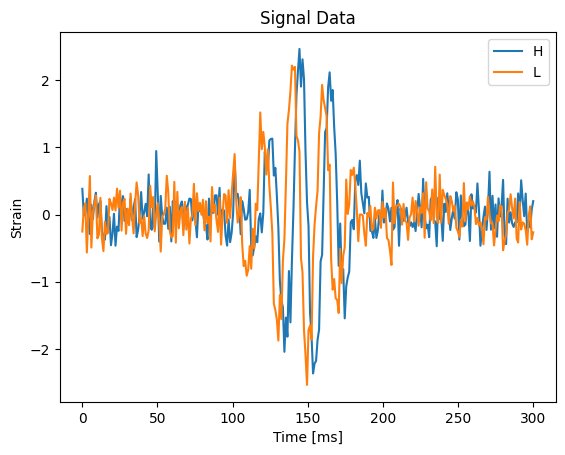

In [11]:
SIGNAL_AMPLITUDE = 120.0  # tweak amplitude to study sensitivity

raw_bkg = gen_bg()
raw_sig = gen_sig(amplitude=SIGNAL_AMPLITUDE)

def combine_signal_with_background(background: np.ndarray, signal: np.ndarray, scale: float = 1.0) -> np.ndarray:
    if background.shape != signal.shape:
        raise ValueError("Signal and background must share identical shape")
    combined = background.copy()
    if not np.allclose(background[:, 0], signal[:, 0], atol=1e-8):
        raise ValueError("Time grids for signal and background do not align")
    combined[:, 1] = background[:, 1] + scale * signal[:, 1]
    combined[:, 2] = background[:, 2] + scale * signal[:, 2]
    return combined

combined_signal_raw = combine_signal_with_background(raw_bkg, raw_sig)
assert np.allclose(combined_signal_raw[:, 0], raw_bkg[:, 0])
assert np.allclose(combined_signal_raw[:, 1] - raw_bkg[:, 1], raw_sig[:, 1])
assert np.allclose(combined_signal_raw[:, 2] - raw_bkg[:, 2], raw_sig[:, 2])
print("Verified: signal is added sample-wise to the background")

print(f"Background shape: {raw_bkg.shape}")
print(f"Signal template shape: {raw_sig.shape}")
print(f"Signal+background combined shape: {combined_signal_raw.shape}")
print("Columns: [time, H, L, H+L, H-L, label]")

plt.clf()
plt.plot(combined_signal_raw[:,0],combined_signal_raw[:,1],label="H")
plt.plot(combined_signal_raw[:,0],combined_signal_raw[:,2],label="L")
plt.ylabel("Strain")
plt.title("Signal Data")
plt.xlabel("Time [ms]")
plt.legend()
plt.plot()


In [12]:
# Cell 2: Define 1D Convolutional Autoencoder

class ConvAutoencoder1D(nn.Module):
    def __init__(self, latent_dim: int = 32):
        super().__init__()
        
        # -------- Encoder --------
        self.encoder_cnn = nn.Sequential(
            # Input: (N, 2, 300)
            nn.Conv1d(in_channels=2, out_channels=16, kernel_size=7, stride=2, padding=3),
            nn.ReLU(inplace=True),  # -> (N, 16, 150)
            
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, stride=2, padding=2),
            nn.ReLU(inplace=True),  # -> (N, 32, 75)
            
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=2, padding=2),
            nn.ReLU(inplace=True),  # -> (N, 64, 38)
        )
        
        # Flatten size after convs: 64 * 38 = 2432
        self.flatten_dim = 64 * 38
        
        self.encoder_fc = nn.Sequential(
            nn.Linear(self.flatten_dim, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, latent_dim)
        )
        
        # -------- Decoder --------
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, self.flatten_dim),
            nn.ReLU(inplace=True),
        )
        
        self.decoder_cnn = nn.Sequential(
            # Start from (N, 64, 38)
            nn.ConvTranspose1d(
                in_channels=64, out_channels=32,
                kernel_size=5, stride=2, padding=2, output_padding=0
            ),  # -> (N, 32, 75)
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose1d(
                in_channels=32, out_channels=16,
                kernel_size=5, stride=2, padding=2, output_padding=1
            ),  # -> (N, 16, 150)
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose1d(
                in_channels=16, out_channels=2,
                kernel_size=7, stride=2, padding=3, output_padding=1
            ),  # -> (N, 2, 300)
            # No activation here (assume inputs are standardized)
        )
    
    def encode(self, x):
        """
        x: (N, 2, 300) -> latent: (N, latent_dim)
        """
        h = self.encoder_cnn(x)            # (N, 64, 38)
        h = h.view(h.size(0), -1)          # (N, 2432)
        z = self.encoder_fc(h)             # (N, latent_dim)
        return z
    
    def decode(self, z):
        """
        z: (N, latent_dim) -> x_recon: (N, 2, 300)
        """
        h = self.decoder_fc(z)             # (N, 2432)
        h = h.view(h.size(0), 64, 38)      # (N, 64, 38)
        x_recon = self.decoder_cnn(h)      # (N, 2, 300)
        return x_recon
    
    def forward(self, x):
        z = self.encode(x)
        x_recon = self.decode(z)
        return x_recon, z

# Instantiate model
model = ConvAutoencoder1D(latent_dim=32).to(device)
model

ConvAutoencoder1D(
  (encoder_cnn): Sequential(
    (0): Conv1d(2, 16, kernel_size=(7,), stride=(2,), padding=(3,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(5,), stride=(2,), padding=(2,))
    (3): ReLU(inplace=True)
    (4): Conv1d(32, 64, kernel_size=(5,), stride=(2,), padding=(2,))
    (5): ReLU(inplace=True)
  )
  (encoder_fc): Sequential(
    (0): Linear(in_features=2432, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=32, bias=True)
  )
  (decoder_fc): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=2432, bias=True)
    (3): ReLU(inplace=True)
  )
  (decoder_cnn): Sequential(
    (0): ConvTranspose1d(64, 32, kernel_size=(5,), stride=(2,), padding=(2,))
    (1): ReLU(inplace=True)
    (2): ConvTranspose1d(32, 16, kernel_size=(5,), stride=(2,), padding=(2,), output_padding=(1,))
    (3): ReLU(inplace=True)


In [13]:
# Cell 3: Example Dataset and DataLoader

class LIGOWindowDataset(Dataset):
    """
    Assumes you have precomputed numpy arrays or tensors:
        hanford_windows: shape (num_windows, 300)
        livingston_windows: shape (num_windows, 300)
    Corresponding windows match along axis 0.
    """
    def __init__(self, hanford_windows, livingston_windows):
        assert hanford_windows.shape == livingston_windows.shape
        assert hanford_windows.shape[1] == 300
        
        # Convert to torch tensors if needed
        self.h = torch.as_tensor(hanford_windows, dtype=torch.float32)
        self.l = torch.as_tensor(livingston_windows, dtype=torch.float32)
        
        # Optional: do global standardization before wrapping in Dataset,
        # or do it here if you prefer.
    
    def __len__(self):
        return self.h.shape[0]
    
    def __getitem__(self, idx):
        # Shape: (2, 300)
        x = torch.stack([self.h[idx], self.l[idx]], dim=0)
        return x

# Example usage with generated background windows
num_windows = 1000
bg_windows = [gen_bg() for _ in range(num_windows)]  # each: (300, 3) [time, H, L]
bg_windows = np.stack(bg_windows, axis=0)  # (num_windows, 300, 3)
dummy_h = bg_windows[:, :, 1]
dummy_l = bg_windows[:, :, 2]

train_dataset = LIGOWindowDataset(dummy_h, dummy_l)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)


Epoch 1/50 | Train MSE: 0.071312
Epoch 2/50 | Train MSE: 0.066816
Epoch 3/50 | Train MSE: 0.064477
Epoch 4/50 | Train MSE: 0.063423
Epoch 5/50 | Train MSE: 0.063047
Epoch 6/50 | Train MSE: 0.062810
Epoch 7/50 | Train MSE: 0.062747
Epoch 8/50 | Train MSE: 0.062738
Epoch 9/50 | Train MSE: 0.062715
Epoch 10/50 | Train MSE: 0.062690
Epoch 11/50 | Train MSE: 0.062679
Epoch 12/50 | Train MSE: 0.062675
Epoch 13/50 | Train MSE: 0.062667
Epoch 14/50 | Train MSE: 0.062662
Epoch 15/50 | Train MSE: 0.062656
Epoch 16/50 | Train MSE: 0.062652
Epoch 17/50 | Train MSE: 0.062649
Epoch 18/50 | Train MSE: 0.062647
Epoch 19/50 | Train MSE: 0.062643
Epoch 20/50 | Train MSE: 0.062640
Epoch 21/50 | Train MSE: 0.062637
Epoch 22/50 | Train MSE: 0.062634
Epoch 23/50 | Train MSE: 0.062631
Epoch 24/50 | Train MSE: 0.062626
Epoch 25/50 | Train MSE: 0.062620
Epoch 26/50 | Train MSE: 0.062611
Epoch 27/50 | Train MSE: 0.062597
Epoch 28/50 | Train MSE: 0.062580
Epoch 29/50 | Train MSE: 0.062553
Epoch 30/50 | Train MSE

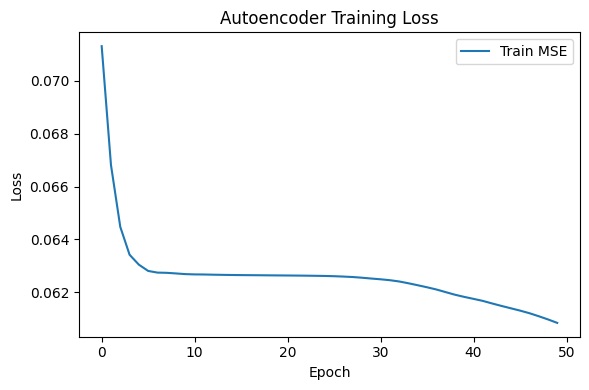

In [14]:
# Cell 4: Training loop

num_epochs = 50
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for batch in train_loader:
        # batch: (B, 2, 300)
        batch = batch.to(device)
        
        optimizer.zero_grad()
        recon, z = model(batch)
        loss = criterion(recon, batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * batch.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs} | Train MSE: {epoch_loss:.6f}")

plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train MSE")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Autoencoder Training Loss")
plt.legend()
plt.tight_layout()
plt.show()


In [15]:
# Cell 5: Anomaly scoring function

def compute_anomaly_scores(model, windows_tensor, batch_size=256):
    """
    windows_tensor: (N, 2, 300) tensor of windows.
    Returns: anomaly_scores: (N,) tensor of reconstruction MSE per window.
    """
    model.eval()
    scores = []
    
    with torch.no_grad():
        for i in range(0, windows_tensor.size(0), batch_size):
            batch = windows_tensor[i:i+batch_size].to(device)
            recon, _ = model(batch)
            
            # Per-window MSE over channels and time
            mse_per_window = ((recon - batch) ** 2).mean(dim=(1, 2))
            scores.append(mse_per_window.cpu())
    
    scores = torch.cat(scores, dim=0)
    return scores

# Example usage on some test tensor: (N_test, 2, 300)
test_windows = torch.randn(500, 2, 300)  # replace with real data
anomaly_scores = compute_anomaly_scores(model, test_windows)
anomaly_scores[:10]

tensor([0.9341, 0.9662, 0.9971, 0.9661, 1.0830, 1.0565, 1.0050, 1.0497, 0.8888,
        0.9667])

Signal score: 0.343355
Signal score percentile vs background: 100.00%


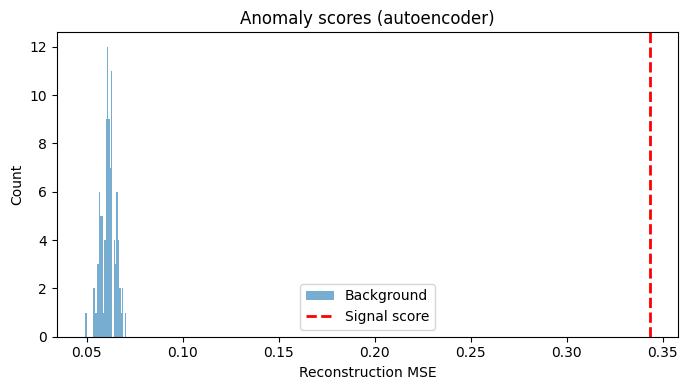

In [16]:
# Evaluate: 100 background windows + 1 injected signal window
num_bg_eval = 100
bg_windows = [gen_bg() for _ in range(num_bg_eval)]  # each (300, 3): [time, H, L]
sig_window = gen_sig(amplitude=SIGNAL_AMPLITUDE)

eval_windows = np.stack(bg_windows + [sig_window], axis=0)  # (num_bg_eval+1, 300, 3)
labels = np.array([0] * num_bg_eval + [1])
perm = np.random.default_rng(2025).permutation(len(labels))
eval_windows = eval_windows[perm]
labels = labels[perm]

h_eval = torch.tensor(eval_windows[:, :, 1], dtype=torch.float32)
l_eval = torch.tensor(eval_windows[:, :, 2], dtype=torch.float32)
windows_tensor = torch.stack([h_eval, l_eval], dim=1)  # (N, 2, 300)

scores = compute_anomaly_scores(model, windows_tensor).cpu().numpy()
sig_score = float(scores[labels == 1][0])
bkg_scores = scores[labels == 0]
percentile = (bkg_scores < sig_score).mean()
print(f"Signal score: {sig_score:.6f}")
print(f"Signal score percentile vs background: {percentile * 100:.2f}%")

plt.figure(figsize=(7, 4))
plt.hist(bkg_scores, bins=30, alpha=0.6, label="Background")
plt.axvline(sig_score, color="red", linestyle="--", linewidth=2, label="Signal score")
plt.xlabel("Reconstruction MSE")
plt.ylabel("Count")
plt.title("Anomaly scores (autoencoder)")
plt.legend()
plt.tight_layout()
plt.show()


In [17]:
# # --- split background into signal/control regions and fit preprocessing ---
# SR_bkg_raw, CR_bkg_raw = gw_background_split(raw_bkg, resample_seed=42)
# # I am instead basing the preprocessing params on the signal region. IMPORTANT NOTE for KRISH
# # pre_params = preprocess_params_fit(CR_bkg_raw)
# SR_sig_raw, CR_sig_raw = gw_background_split(combined_signal_raw, resample_seed=42)
# pre_params = preprocess_params_fit(SR_sig_raw)
# feature_min = pre_params["min"]
# feature_max = pre_params["max"]
# feature_range = feature_max - feature_min
# buffer = np.maximum(feature_range * 0.1, 1e-3)
# pre_params["min"] = feature_min - buffer
# pre_params["max"] = feature_max + buffer
# print("Pre_params:", pre_params)

# def transform_with_params(data, params, clip_eps=1e-6):
#     feature_min = params["min"]
#     feature_max = params["max"]
#     feature_mean = params["mean"]
#     feature_std = params["std"]

#     denom = feature_max - feature_min
#     denom = np.where(denom == 0, 1e-6, denom)
#     x = data[:, 1:-1]
#     x_norm = (x - feature_min) / denom
#     x_norm = np.clip(x_norm, clip_eps, 1 - clip_eps)
#     logit = np.log(x_norm / (1 - x_norm))
#     mask = np.isfinite(logit).all(axis=1)

#     transformed = np.hstack([data[:, 0:1], logit, data[:, -1:]])[mask]
#     transformed[:, 1:-1] = standardize(transformed[:, 1:-1], feature_mean, feature_std)
#     return transformed, data[mask]

# CR_processed, CR_aligned_raw = transform_with_params(CR_bkg_raw, pre_params)
# SR_bkg_processed, SR_bkg_aligned_raw = transform_with_params(SR_bkg_raw, pre_params)
# SR_sig_processed, SR_sig_aligned_raw = transform_with_params(SR_sig_raw, pre_params)

# print(f"Control-region processed shape: {CR_processed.shape}")
# print(f"Signal-region background shape: {SR_bkg_processed.shape}")
# print(f"Signal-region injected signal shape: {SR_sig_processed.shape}")

# # Build background mass/time PDF for later mixing
# hist_counts, hist_bins = np.histogram(SR_bkg_aligned_raw[:, 0], bins=40, density=True)
# mass_density = rv_histogram((hist_counts, hist_bins))

# plt.clf()
# # plt.scatter(SR_bkg_raw[:, 0], SR_bkg_raw[:, 1], label='Signal Region Background Time Distribution')
# # plt.scatter(CR_bkg_raw[:, 0], CR_bkg_raw[:, 1], label='Control Region Background Time Distribution')
# plt.scatter(SR_bkg_processed[:, 0], SR_bkg_processed[:, 1], label='Processed Signal Region Background Time Distribution')
# plt.scatter(SR_sig_processed[:, 0], SR_sig_processed[:, 1], label='Processed Signal+Background Time Distribution')
# # plt.scatter(CR_sig_raw[:, 0], CR_sig_raw[:, 1], label='Signal Region Raw Signal+Background Time Distribution')
# plt.scatter(CR_processed[:, 0], CR_processed[:, 1], label='Processed Control Region Background Time Distribution')
# plt.xlabel('Time (s)')
# plt.ylabel('Strain')
# plt.legend()
# plt.title('Gravitational Wave Data Processing')
# plt.show()